# lab 7

# Supermodeling

## What is supermodeling

## Used Data Assimilation method

## Submodels

## Lorenz again

![Lorenz equations](images/lorenz.png)

source: https://en.wikipedia.org/wiki/Lorenz_system

### Utilities

In [203]:
from operator import itemgetter
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

In [444]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed


def plot_models(models, figsize=(8,8)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection="3d")
    for piece in models:
            ax.plot(piece[:, 0].flatten(), piece[:, 1].flatten(), piece[:, 2].flatten(), lw=0.5)
    plt.draw()
    plt.show()
    
def plot_model(model, figsize=(5,5)):
    plot_models([model], figsize)

    
def calc_mean_lorenz(lorenz_models):
    return np.array([np.mean(lorenz_models[:,i,:], axis=0) for i in range(lorenz_models.shape[1])])


def calc_weighted_average_lorenz(lorenz_models, weights):
    return np.array([np.average(lorenz_models[:,i,:], axis=0, weights=weights) for i in range(lorenz_models.shape[1])])

def lorenz_step(coords, t, parameters):
    rho, sigma, beta = parameters
    x, y, z = coords
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def generate_lorenz(x=1, y=1, z=1, sigma=10.0, rho=28.0, beta=8.0/3.0, start_time=0, number_of_samples=2000):
    start_coords = [x, y, z]
    parameters = [rho, sigma, beta]
    dt = 0.02
    stop = (number_of_samples+start_time)*dt
#     t = np.linspace(start, stop, num=number_of_samples+(start_time/0.02))
    t = np.arange(0.0, stop, dt)

    return odeint(lorenz_step, start_coords, t, args=(parameters,))[start_time:,:], t[start_time:]

def plot_models_coords_in_time(models, timelines):
    f, (px, py, pz) = plt.subplots(3, 1, sharex=True, figsize=(15,8))

    px.set_ylabel("X component")
    py.set_ylabel("Y component")
    pz.set_ylabel("Z component")
    
    for ix, (model, timeline) in enumerate(zip(models, timelines)):
        px.plot(timeline, model[:,0], lw=0.5)
        py.plot(timeline, model[:,1], lw=0.5)
        pz.plot(timeline, model[:,2], lw=0.5, label=str(ix+1))

    pz.set_xlabel("Time index (x 100)")
    
    f.legend(title="Models in order")
    

def plot_model_coords_in_time(model, timeline):
    plot_models_coords_in_time([model], [timeline])

In [269]:
l63[:,1].shape

(100,)

### Sandbox

[0.0000000e+00 2.0010005e-02 4.0020010e-02 ... 3.9959980e+01 3.9979990e+01
 4.0000000e+01]


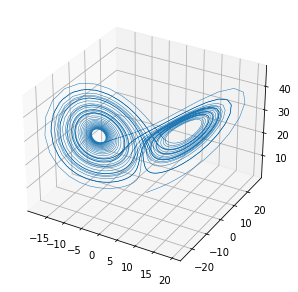

In [205]:
# generate and plot lorenz attractor
lorenz_attr = generate_lorenz()
plot_model(lorenz_attr)

In [378]:
model_1_params = dict(
    x = 1,
    y = 1,
    z = 1,
    sigma = 13.25,
    rho = 19.0,
    beta = 3.5
)

model_2_params = dict(
    x = 1,
    y = 1,
    z = 1,
    sigma = 7.0,
    rho = 18.0,
    beta = 3.7
)


model_3_params = dict(
    x = 1,
    y = 1,
    z = 1,
    sigma = 6.5,
    rho = 38.0,
    beta = 1.7
)

models_start = 15
number_of_samples = 200

m1, t1 = generate_lorenz(start_time=models_start, number_of_samples=number_of_samples,**model_1_params)
m2, t2 = generate_lorenz(start_time=models_start, number_of_samples=number_of_samples, **model_2_params)
m3, t3 = generate_lorenz(start_time=models_start, number_of_samples=number_of_samples, **model_3_params)

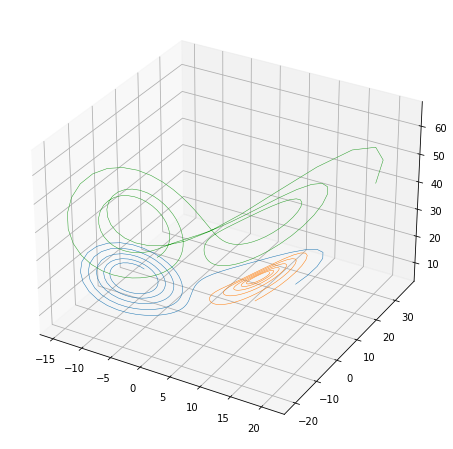

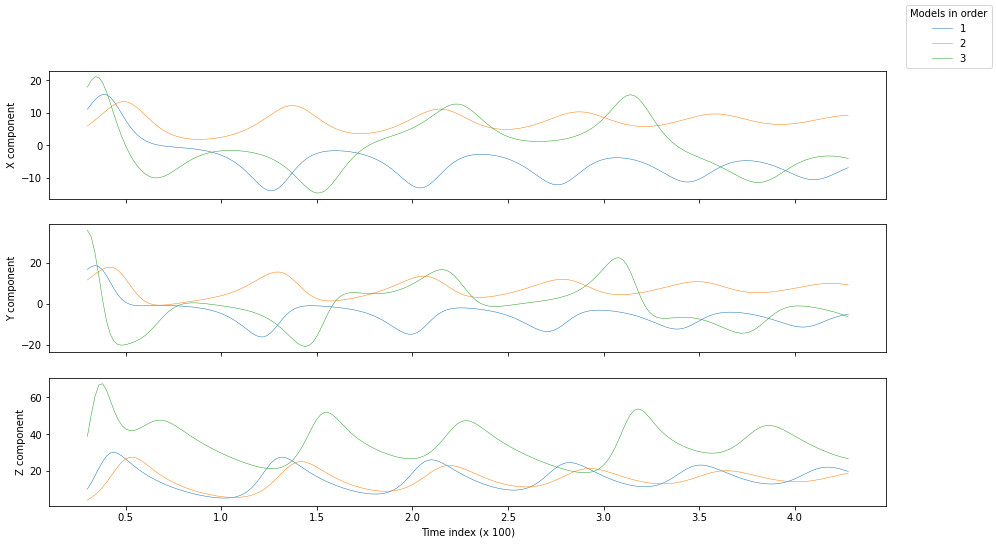

In [385]:
plot_models([m1,m2,m3])
plot_models_coords_in_time([m1,m2,m3], [t1,t2,t3])

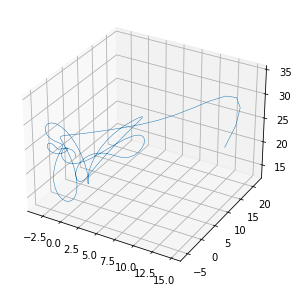

In [382]:
mean_model = calc_mean_lorenz(np.array([m1, m2, m3]))
plot_model(mean_model)

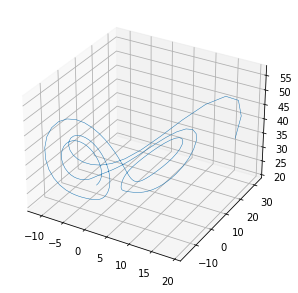

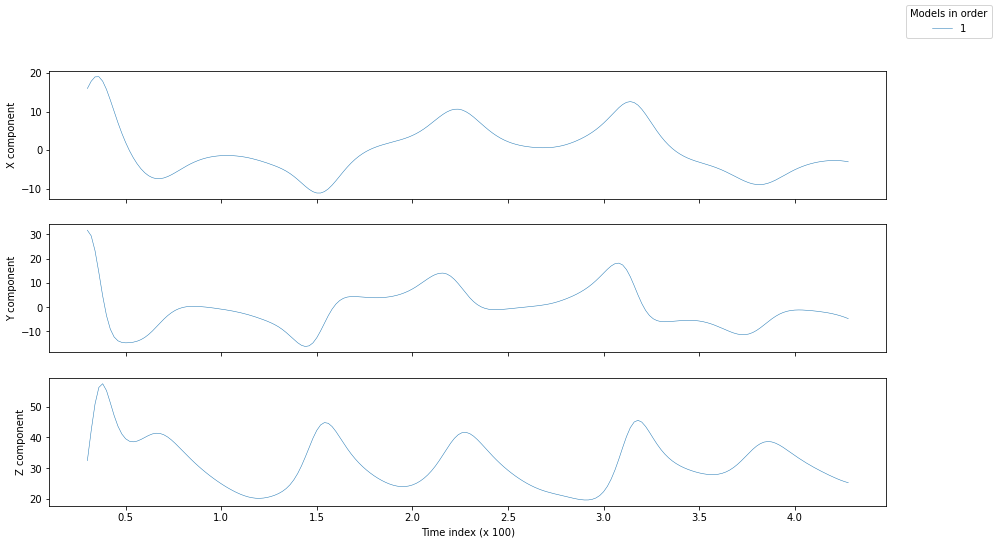

In [386]:
weighted_avg_model = calc_weighted_average_lorenz(
    np.array([m1, m2, m3]),
    [0.1,0.1,0.8]
)

plot_model(weighted_avg_model)
plot_model_coords_in_time(weighted_avg_model, t1)

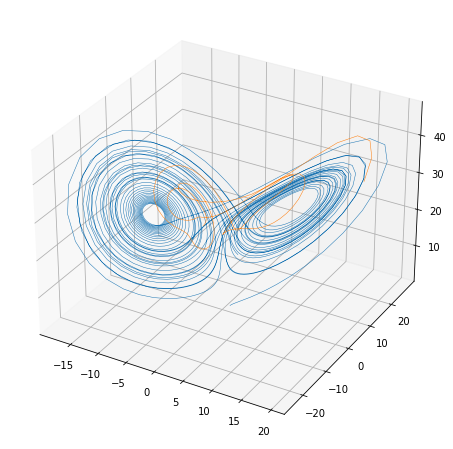

In [389]:
weighted_avg_model = calc_weighted_average_lorenz(
    np.array([m1, m2, m3]),
    [1,1,3]
)

plot_models([lorenz_attr,weighted_avg_model])

In [440]:
lorenz, lorenz_timeline = generate_lorenz()
plot_model(lorenz)
plot_model_coords_in_time(lorenz, lorenz_timeline)

NameError: name 'start' is not defined

## Task 1 - choose a fragment of lorenz 63 attractor

In [448]:
models_start = 800
number_of_samples = 200

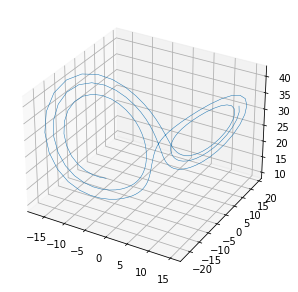

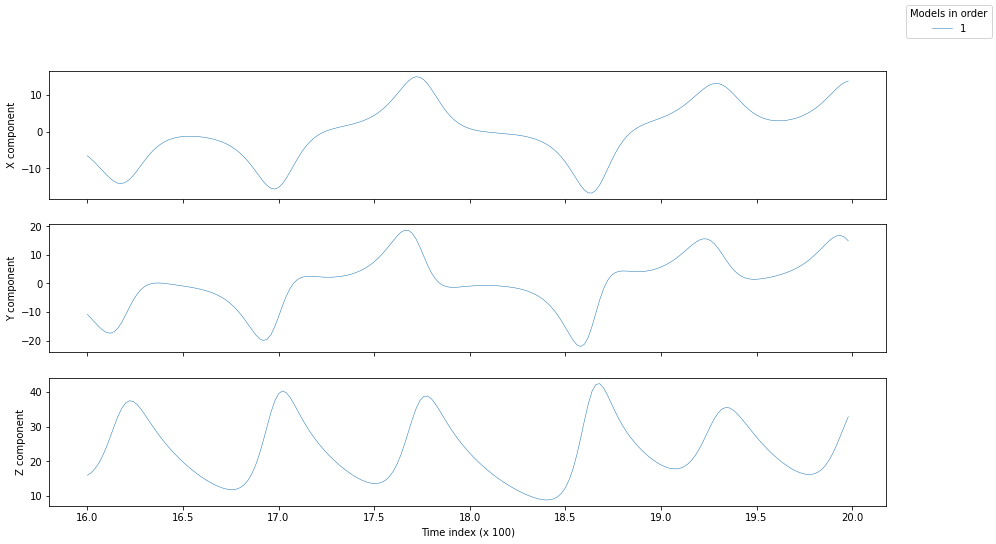

In [449]:
l63, l63_timeline = generate_lorenz(
    start_time=models_start, 
    number_of_samples=number_of_samples
)
plot_model(l63)
plot_model_coords_in_time(l63, l63_timeline)

## Task 2 - have fun with 4dvar

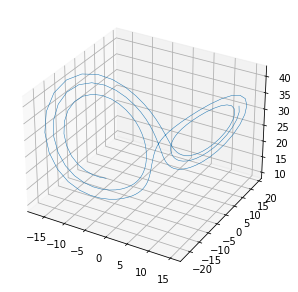

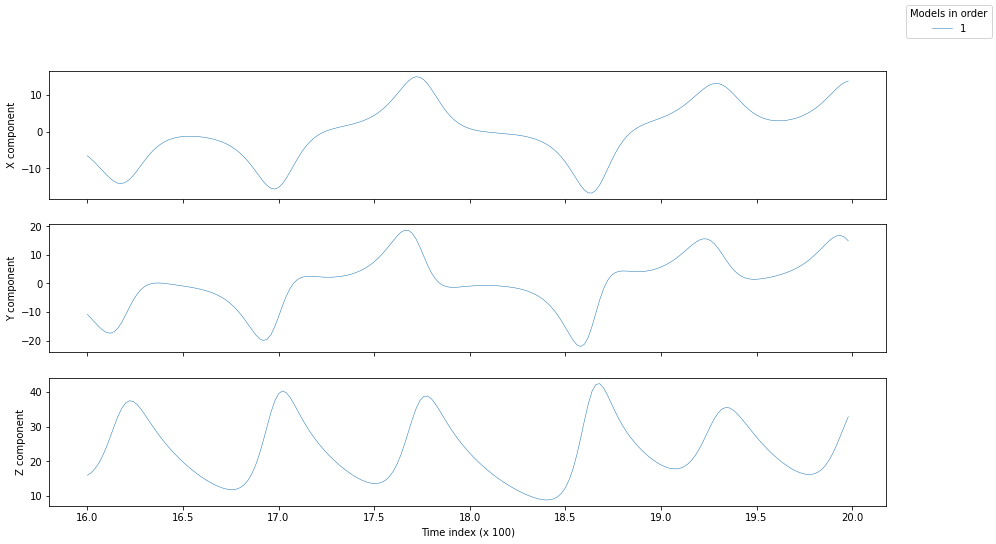

In [453]:
l63_test, l63_timeline_test = generate_lorenz(
    x=l63[0][0],
    y=l63[0][1],
    z=l63[0][2],
    start_time=0, 
    number_of_samples=number_of_samples
)
plot_model(l63)
plot_model_coords_in_time(l63, l63_timeline)

In [450]:
l63.shape

(200, 3)

In [452]:
l63[0]

array([ -6.60090965, -10.83557962,  15.89065747])